In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralbridge.stochastic_processes.examples import CellDiffusionProcess, CellDiffusionAuxProcess
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.stochastic_processes.conds import GuidedBridgeProcess
from neuralbridge.networks.mlps import MLPSmall, MLP
from neuralbridge.models import neurb, pCN, scorematching
from neuralbridge.utils.plotting import plot_sample_path

# Guiding conditional cell diffusion process
We now exam a cell differentiation and development model from _Quantifying the Waddington landscape and biological paths for development and differentiation. Wang et.al._, which is a two-dimensional diffusion process governed by the pair of 1D SDEs:
$$
\mathrm{d}X_{t,1} = \left\{\frac{X^4_{t,1}}{2^{-4} + X^4_{t,1}} + \frac{X^4_{t,2}}{2^{-4} + X^4_{t,2}} - X_{t,1}\right\}\mathrm{d}t + \sigma\mathrm{d}W_{t,1} \\
\mathrm{d}X_{t,2} = \left\{\frac{X^4_{t,2}}{2^{-4} + X^4_{t,2}} + \frac{X^4_{t,1}}{2^{-4} + X^4_{t,1}} - X_{t,2}\right\}\mathrm{d}t + \sigma\mathrm{d}W_{t,2},
$$
which is a highly nonlinear process with no closed-form solution of conditional bridges. We choose the linear auxiliary process as:
$$
\mathrm{d}\tilde{X}_{t,1} = - \tilde{X}_{t,1}\mathrm{d}t + \sigma\mathrm{d}W_{t,1}\\
\mathrm{d}\tilde{X}_{t,2} = - \tilde{X}_{t,2}\mathrm{d}t + \sigma\mathrm{d}W_{t,2},
$$
which is a 2D Ornstein-Uhlenbeck process.

### Conditioning on normal events

In [6]:
dim = 2
T = 4.0
dt = 1.0 / 100
dtype = jnp.float32

alpha = 1. / 16.
sigma = 0.1

seed = 42
u = jnp.array([0.1, -0.1], dtype=dtype)
v = jnp.array([2.0, -0.1], dtype=dtype)
# v = jnp.array([1.0, -0.1], dtype=dtype) # probably rare event

In [7]:
t_scheme = "linear"
ode_solver_kernel = "dopri5"

wiener_proc = WienerProcess(T, dt, dim, dtype, t_scheme)
ori_proc = CellDiffusionProcess(alpha, sigma, T, dim, dtype)
aux_proc = CellDiffusionAuxProcess(alpha, sigma, T, dim, dtype)

guided_proc = GuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    u=u,
    v=v,
    L0=jnp.eye(dim, dtype=dtype), 
    Sigma0=jnp.eye(dim, dtype=dtype)*1e-10, 
    ts=jnp.arange(0, T + dt, dt, dtype=dtype),
    ode_solver_kernel=ode_solver_kernel
)

ori_solver = Euler(sde=ori_proc, wiener=wiener_proc)
aux_solver = Euler(sde=aux_proc, wiener=wiener_proc)
guided_solver = Euler(sde=guided_proc, wiener=wiener_proc)

rng_key = jax.random.PRNGKey(seed)

<Axes: title={'center': 'Guided Process'}, xlabel='$t$', ylabel='$x$'>

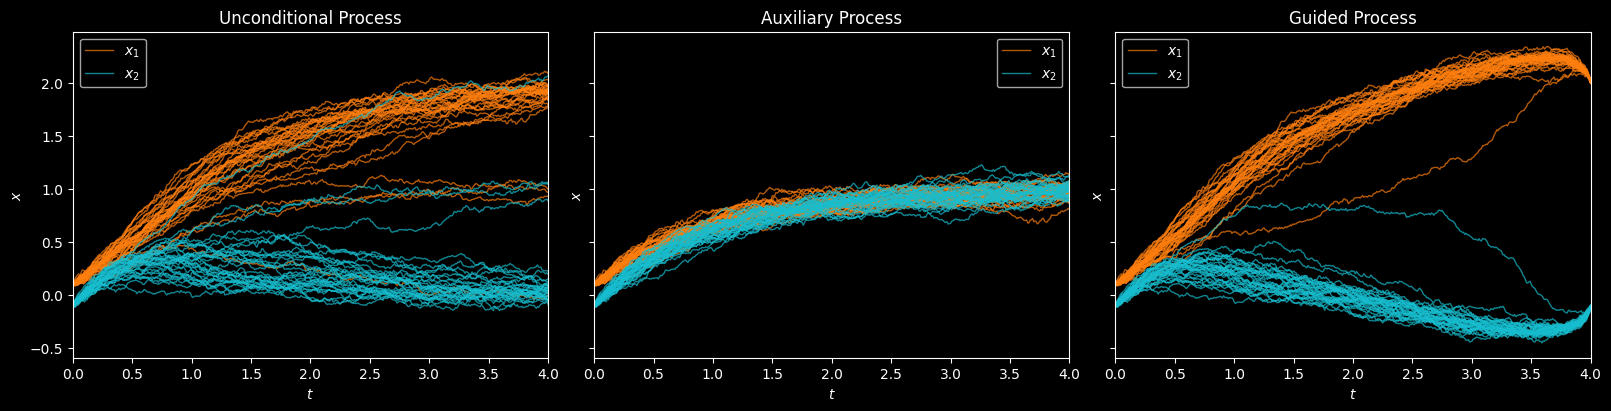

In [8]:
batch_size = 32
ori_path = ori_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
aux_path = aux_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
guided_path = guided_solver.solve(
    x0=u, 
    rng_key=rng_key, 
    batch_size=batch_size, 
    enforce_end_point=v
)

fig, axes = plt.subplots(1, 3, figsize=(16, 4), layout="constrained", sharey=True)
plot_sample_path(ori_path, ax=axes[0], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Unconditional Process")
plot_sample_path(aux_path, ax=axes[1], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Auxiliary Process")
plot_sample_path(guided_path, ax=axes[2], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Guided Process")

In [9]:
neural_net = MLPSmall(
    out_dim=dim,
    hidden_dims=(32, 32, 32, 32),
    activation="tanh",
    norm=None
)

In [10]:
train_config = {
    "save_name": "cell_model_tanh_1e-1sigma_4T",
    "seed": seed,
    "learning_rate": 5e-4,
    "batch_size": 64,
    "n_iters": 200,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 0
}

In [11]:
neural_bridge = neurb.NeuralBridge(
    guided_bridge=guided_proc,
    neural_net=neural_net,
    train_config=train_config
)
wiener_proc = WienerProcess(T, dt, dim, dtype, t_scheme)
neural_bridge.initialize_path_solver(wiener_proc)

In [12]:
losses = neural_bridge.train_neural_bridge(u=u, v=v, mode="pretrained")

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/type_handlers.py:1386: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T
INFO:root:Loading pretrained model from the last epoch


In [13]:
neural_bridge_path = neural_bridge.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)

In [14]:
pCN_config = {
    "seed": seed,
    "rho": 0.98,
    "batch_size": 16,
    "n_iters": 10000
}
pCN_model = pCN.PreconditionedCrankNicolson(guided_bridge=guided_proc, run_config=pCN_config)
pCN_model.initialize_path_solver(wiener_proc)
pCN_result = pCN_model.run_pCN(log_every=1000)

Running for 10,000 iterations:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:root:Iteration 0/10000: log likelihood = 169.13661193847656
INFO:root:Iteration 1000/10000: log likelihood = 293.79364013671875
INFO:root:Iteration 2000/10000: log likelihood = 286.0283508300781
INFO:root:Iteration 3000/10000: log likelihood = 290.6103515625
INFO:root:Iteration 4000/10000: log likelihood = 282.71624755859375
INFO:root:Iteration 5000/10000: log likelihood = 261.9419860839844
INFO:root:Iteration 6000/10000: log likelihood = 293.9814758300781
INFO:root:Iteration 7000/10000: log likelihood = 275.2231750488281
INFO:root:Iteration 8000/10000: log likelihood = 281.37481689453125
INFO:root:Iteration 9000/10000: log likelihood = 250.9185028076172
INFO:root:Batch average acceptance rate: 28.11%


In [15]:
sm_train_config = {
    "save_name": "cell_model_1e-1sigma_4T",
    "seed": seed,
    "learning_rate": 2e-4,
    "batch_size": 32,
    "n_iters": 2000,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 2000
}

In [16]:
neural_net = MLP(
    out_dim=dim, 
    hidden_dims=(32, 32, 32, 32),
    norm="batch",
    t_emb_dim=32,
    t_emb_max_period=200.0,
    t_emb_scaling=100.0
)
sm_reverse_bridge = scorematching.ScoreMatchingReversedBridge(ori_proc, neural_net, sm_train_config)
sm_reverse_bridge.initialize_path_solver(wiener_proc)
losses = sm_reverse_bridge.train_reversed_bridge(u=u, v=v, mode="pretrained")

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/type_handlers.py:1386: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model_1e-1sigma_4T
INFO:root:Loading pretrained model from the last epoch


In [17]:
reversed_bridge = sm_reverse_bridge.build_reversed_bridge()
reversed_bridge_solver = Euler(reversed_bridge, wiener_proc)
reversed_bridge_path = reversed_bridge_solver.solve(x0=v, rng_key=jax.random.PRNGKey(seed), batch_size=16, enforce_end_point=u)

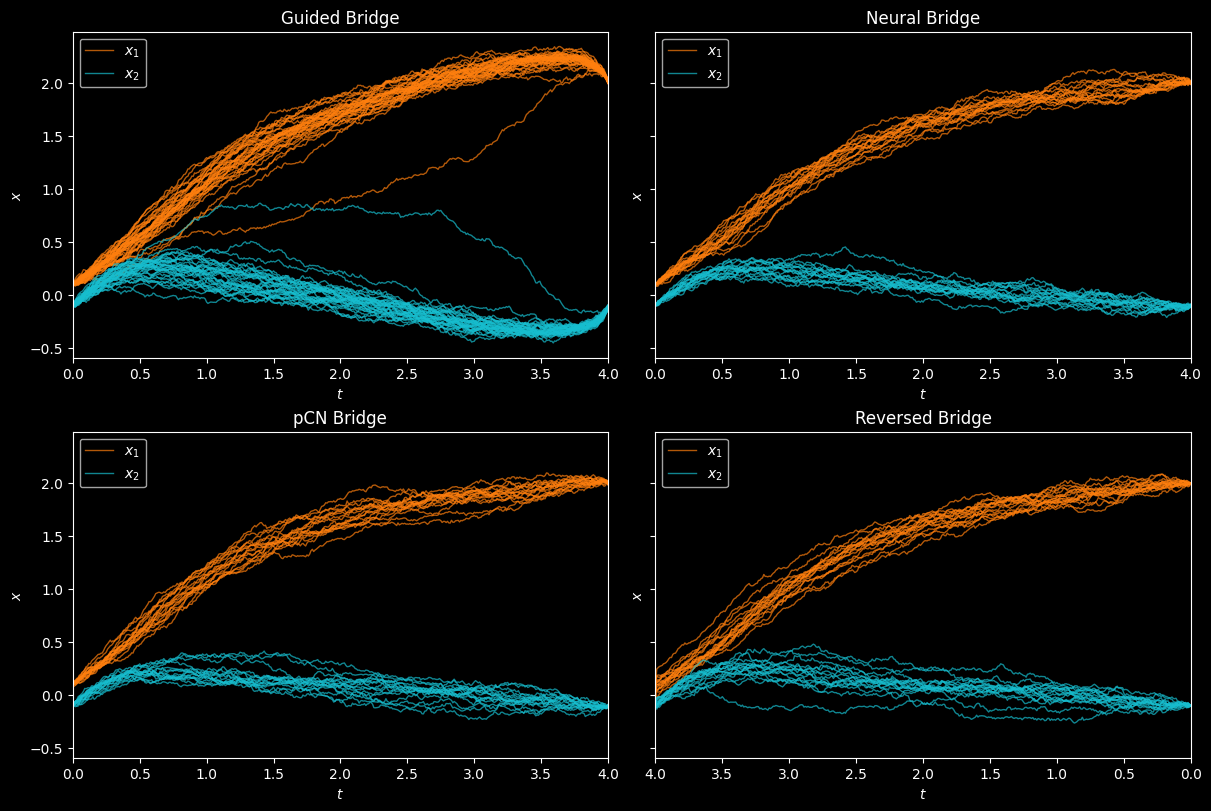

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), layout="constrained", sharey=True)
plot_sample_path(guided_path, ax=ax[0, 0], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Guided Bridge")
plot_sample_path(neural_bridge_path, ax=ax[0, 1], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Neural Bridge")
plot_sample_path(pCN_result.path_X, ax=ax[1, 0], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="pCN Bridge")
plot_sample_path(reversed_bridge_path, ax=ax[1, 1], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Reversed Bridge")
ax[1, 1].invert_xaxis()

### Conditioning on rare events

In [20]:
dim = 2
T = 4.0
dt = 1.0 / 100
dtype = jnp.float32

alpha = 1. / 16.
sigma = 0.1

seed = 42
u = jnp.array([0.1, -0.1], dtype=dtype)
# v = jnp.array([2.0, -0.1], dtype=dtype)
v = jnp.array([1.0, -0.1], dtype=dtype) # probably rare event

In [21]:
guided_proc = GuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    u=u,
    v=v,
    L0=jnp.eye(dim, dtype=dtype), 
    Sigma0=jnp.eye(dim, dtype=dtype)*1e-10, 
    ts=jnp.arange(0, T + dt, dt, dtype=dtype),
    ode_solver_kernel=ode_solver_kernel
)

guided_solver = Euler(sde=guided_proc, wiener=wiener_proc)

rng_key = jax.random.PRNGKey(seed)

<Axes: title={'center': 'Guided Process'}, xlabel='$t$', ylabel='$x$'>

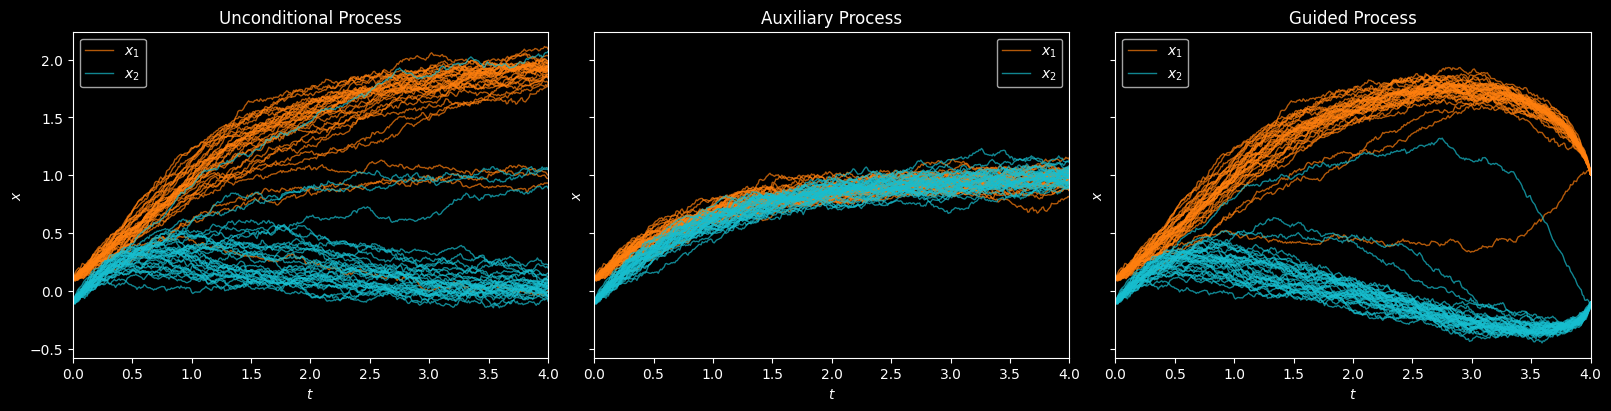

In [22]:
batch_size = 32
ori_path = ori_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
aux_path = aux_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
guided_path = guided_solver.solve(
    x0=u, 
    rng_key=rng_key, 
    batch_size=batch_size, 
    enforce_end_point=v
)

fig, axes = plt.subplots(1, 3, figsize=(16, 4), layout="constrained", sharey=True)
plot_sample_path(ori_path, ax=axes[0], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Unconditional Process")
plot_sample_path(aux_path, ax=axes[1], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Auxiliary Process")
plot_sample_path(guided_path, ax=axes[2], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Guided Process")

In [23]:
neural_net = MLPSmall(
    out_dim=dim,
    hidden_dims=(32, 32, 32, 32),
    activation="tanh",
    norm=None
)

train_config = {
    "save_name": "cell_model_tanh_1e-1sigma_4T_rare_event",
    "seed": seed,
    "learning_rate": 5e-4,
    "batch_size": 64,
    "n_iters": 200,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 0
}

In [24]:
neural_bridge = neurb.NeuralBridge(
    guided_bridge=guided_proc,
    neural_net=neural_net,
    train_config=train_config
)
wiener_proc = WienerProcess(T, dt, dim, dtype, t_scheme)
neural_bridge.initialize_path_solver(wiener_proc)
losses = neural_bridge.train_neural_bridge(u=u, v=v, mode="train")

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 1 average loss: -25.74751
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T_rare_event/epoch_1


Epoch 2:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 2 average loss: -35.87242
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T_rare_event/epoch_2


Epoch 3:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 3 average loss: -44.62821
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T_rare_event/epoch_3


Epoch 4:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 4 average loss: -47.23687
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T_rare_event/epoch_4


Epoch 5:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 5 average loss: -49.82687
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T_rare_event/epoch_5


Epoch 6:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 6 average loss: -50.97953
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T_rare_event/epoch_6


Epoch 7:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 7 average loss: -51.77215
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T_rare_event/epoch_7


Epoch 8:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 8 average loss: -52.30103
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T_rare_event/epoch_8


Epoch 9:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 9 average loss: -52.27028
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T_rare_event/epoch_9


Epoch 10:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 10 average loss: -52.38475
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T_rare_event/epoch_10


In [25]:
neural_bridge_path = neural_bridge.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)

In [26]:
pCN_config = {
    "seed": seed,
    "rho": 0.98,
    "batch_size": 16,
    "n_iters": 10000
}
pCN_model = pCN.PreconditionedCrankNicolson(guided_bridge=guided_proc, run_config=pCN_config)
pCN_model.initialize_path_solver(wiener_proc)
pCN_result = pCN_model.run_pCN(log_every=1000)

Running for 10,000 iterations:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:root:Iteration 0/10000: log likelihood = -0.7861402630805969
INFO:root:Iteration 1000/10000: log likelihood = 114.35957336425781
INFO:root:Iteration 2000/10000: log likelihood = 119.75904846191406
INFO:root:Iteration 3000/10000: log likelihood = 110.30244445800781
INFO:root:Iteration 4000/10000: log likelihood = 115.11449432373047
INFO:root:Iteration 5000/10000: log likelihood = 111.67157745361328
INFO:root:Iteration 6000/10000: log likelihood = 128.58480834960938
INFO:root:Iteration 7000/10000: log likelihood = 103.92985534667969
INFO:root:Iteration 8000/10000: log likelihood = 100.34174346923828
INFO:root:Iteration 9000/10000: log likelihood = 90.2337646484375
INFO:root:Batch average acceptance rate: 14.20%


Text(0.5, 0.98, 'Conditioning on Rare Events')

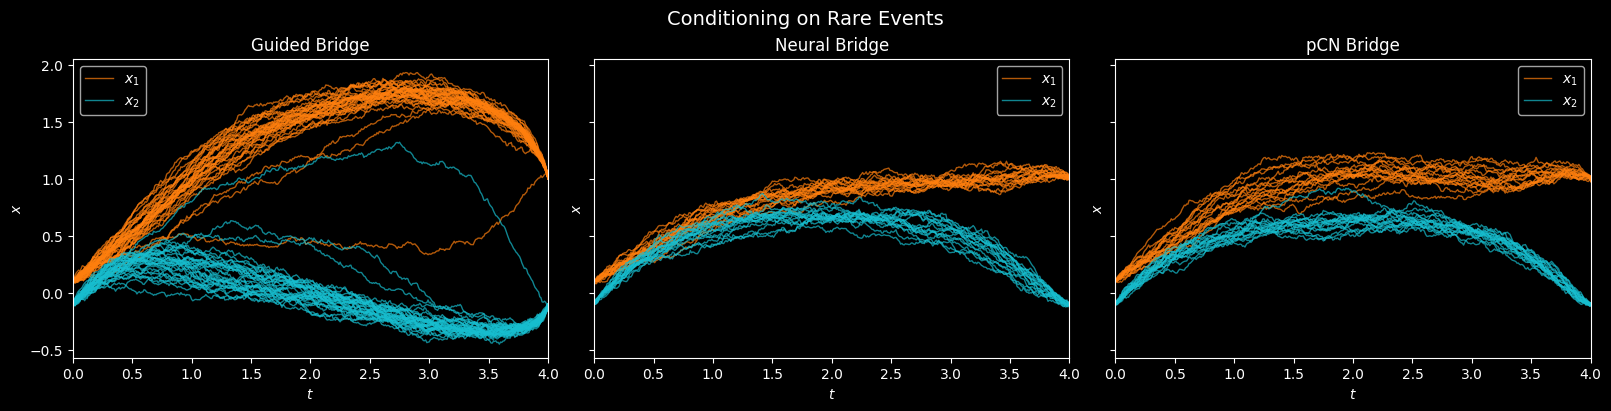

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), layout="constrained", sharey=True)
plot_sample_path(guided_path, ax=ax[0], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Guided Bridge")
plot_sample_path(neural_bridge_path, ax=ax[1], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Neural Bridge")
plot_sample_path(pCN_result.path_X, ax=ax[2], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="pCN Bridge")
fig.suptitle("Conditioning on Rare Events", fontsize=14)

### Multi-modality

In [29]:
dim = 2
T = 5.0
dt = 1.0 / 100
dtype = jnp.float32

alpha = 1. / 16.
sigma = 0.1

seed = 42
u = jnp.array([-1.0, -1.0], dtype=dtype)
v = jnp.array([-1.0, -1.0], dtype=dtype) # The event that cause the multi-modality

In [30]:
guided_proc = GuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    u=u,
    v=v,
    L0=jnp.eye(dim, dtype=dtype), 
    Sigma0=jnp.eye(dim, dtype=dtype)*1e-10, 
    ts=jnp.arange(0, T + dt, dt, dtype=dtype),
    ode_solver_kernel=ode_solver_kernel
)

guided_solver = Euler(sde=guided_proc, wiener=wiener_proc)

rng_key = jax.random.PRNGKey(seed)

<Axes: title={'center': 'Guided Process'}, xlabel='$t$', ylabel='$x$'>

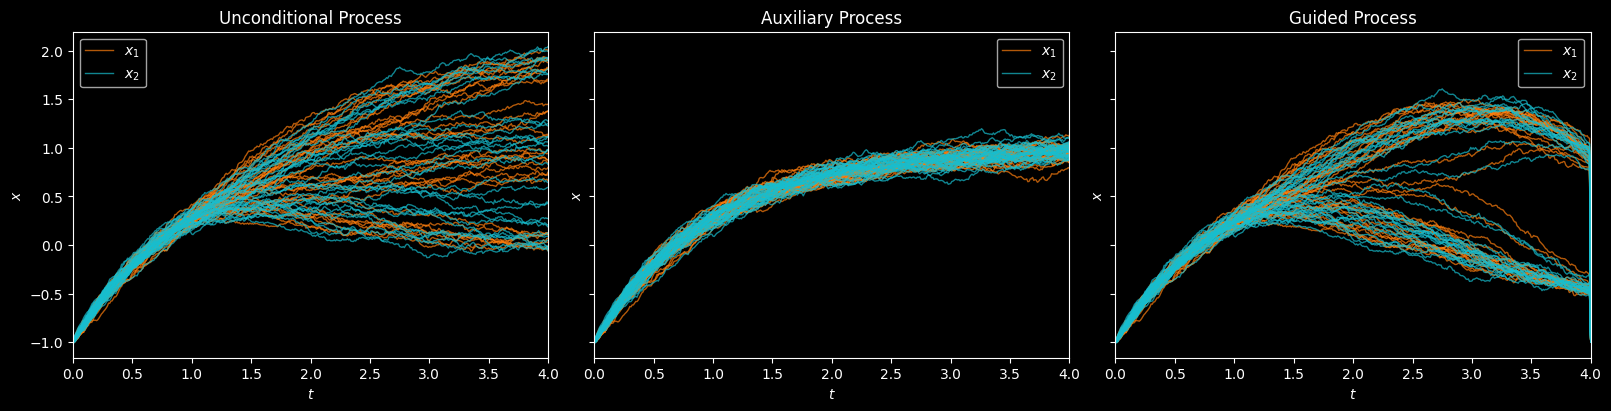

In [31]:
batch_size = 32
ori_path = ori_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
aux_path = aux_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
guided_path = guided_solver.solve(
    x0=u, 
    rng_key=rng_key, 
    batch_size=batch_size, 
    enforce_end_point=v
)

fig, axes = plt.subplots(1, 3, figsize=(16, 4), layout="constrained", sharey=True)
plot_sample_path(ori_path, ax=axes[0], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Unconditional Process")
plot_sample_path(aux_path, ax=axes[1], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Auxiliary Process")
plot_sample_path(guided_path, ax=axes[2], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Guided Process")

In [48]:
neural_net = MLPSmall(
    out_dim=dim,
    hidden_dims=(32, 32, 32, 32),
    activation="tanh",
    norm=None
)

train_config = {
    "save_name": "cell_model_tanh_1e-1sigma_5T_multi_modality",
    "seed": seed,
    "learning_rate": 4e-4,
    "batch_size": 64,
    "n_iters": 500,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 500
}

In [49]:
neural_bridge = neurb.NeuralBridge(
    guided_bridge=guided_proc,
    neural_net=neural_net,
    train_config=train_config
)
wiener_proc = WienerProcess(T, dt, dim, dtype, t_scheme)
neural_bridge.initialize_path_solver(wiener_proc)
losses = neural_bridge.train_neural_bridge(u=u, v=v, mode="train")

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 1 average loss: 6.81970
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_5T_multi_modality/epoch_1


Epoch 2:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 2 average loss: 5.30959
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_5T_multi_modality/epoch_2


Epoch 3:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 3 average loss: 4.11595
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_5T_multi_modality/epoch_3


Epoch 4:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 4 average loss: 3.45456
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_5T_multi_modality/epoch_4


Epoch 5:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 5 average loss: 3.19860
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_5T_multi_modality/epoch_5


Epoch 6:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 6 average loss: 3.05945
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_5T_multi_modality/epoch_6


Epoch 7:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 7 average loss: 3.01002
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_5T_multi_modality/epoch_7


Epoch 8:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 8 average loss: 2.98806
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_5T_multi_modality/epoch_8


Epoch 9:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 9 average loss: 2.93588
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_5T_multi_modality/epoch_9


Epoch 10:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 10 average loss: 2.94716
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_5T_multi_modality/epoch_10


In [50]:
neural_bridge_path = neural_bridge.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=64)

In [58]:
pCN_config = {
    "seed": seed,
    "rho": 0.8,
    "batch_size": 64,
    "n_iters": 5000
}
pCN_model = pCN.PreconditionedCrankNicolson(guided_bridge=guided_proc, run_config=pCN_config)
pCN_model.initialize_path_solver(wiener_proc)
pCN_result = pCN_model.run_pCN(log_every=500)

Running for 5,000 iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

INFO:root:Iteration 0/5000: log likelihood = -10.86420726776123
INFO:root:Iteration 500/5000: log likelihood = -0.31484460830688477
INFO:root:Iteration 1000/5000: log likelihood = -3.780038356781006
INFO:root:Iteration 1500/5000: log likelihood = -0.4229729175567627
INFO:root:Iteration 2000/5000: log likelihood = 1.817401647567749
INFO:root:Iteration 2500/5000: log likelihood = -2.977393865585327
INFO:root:Iteration 3000/5000: log likelihood = 0.6984292268753052
INFO:root:Iteration 3500/5000: log likelihood = 1.7814221382141113
INFO:root:Iteration 4000/5000: log likelihood = -0.6574066281318665
INFO:root:Iteration 4500/5000: log likelihood = 5.805532455444336
INFO:root:Batch average acceptance rate: 16.22%


Text(0.5, 0.98, 'Conditioning on Events that cause Multi-modality')

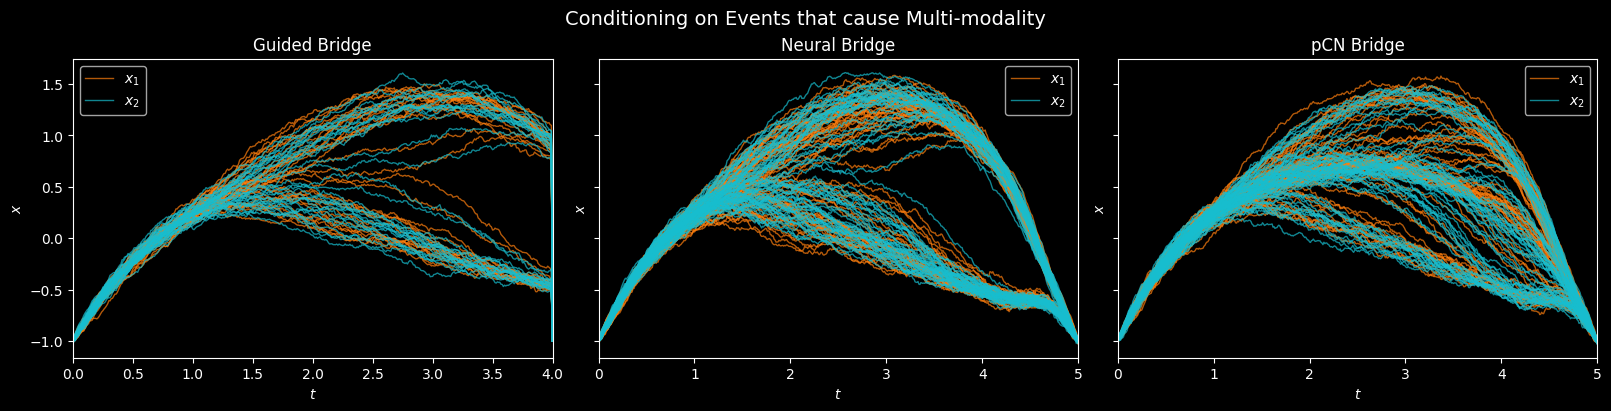

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), layout="constrained", sharey=True)
plot_sample_path(guided_path, ax=ax[0], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Guided Bridge")
plot_sample_path(neural_bridge_path, ax=ax[1], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Neural Bridge")
plot_sample_path(pCN_result.path_X, ax=ax[2], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="pCN Bridge")
fig.suptitle("Conditioning on Events that cause Multi-modality", fontsize=14)